In [115]:
#pip install tensorflow

In [116]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [117]:
df = pd.read_excel("updated_dataset_final - Copy.xlsx", parse_dates=['TANGGAL']) #parse = untuk ngubah kolom tanggal jadi datetime
df = df.sort_values('TANGGAL')
df = df.reset_index(drop=True)

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4013 entries, 0 to 4012
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   TANGGAL  4013 non-null   datetime64[ns]
 1   TN       4013 non-null   float64       
 2   TX       4013 non-null   float64       
 3   TAVG     4013 non-null   float64       
 4   RH_AVG   4013 non-null   float64       
 5   RR       4013 non-null   float64       
 6   SS       4013 non-null   float64       
 7   FF_X     4013 non-null   int64         
 8   DDD_X    4013 non-null   int64         
 9   FF_AVG   4013 non-null   int64         
 10  DDD_CAR  4013 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(4)
memory usage: 345.0 KB


In [119]:
df.tail(5)

,TANGGAL,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR
4008,2025-11-26,26.4,34.8,29.9,64.0,0.0,6.4,3,240,1,0
4009,2025-11-27,26.6,32.8,29.4,70.0,0.0,3.5,4,300,1,0
4010,2025-11-28,26.8,32.5,30.0,66.0,0.0,3.0,4,340,1,0
4011,2025-11-29,27.2,33.0,29.2,71.0,0.0,2.9,4,290,2,0
4012,2025-11-30,27.2,32.6,29.3,70.0,1.0,4.8,6,90,2,0


In [120]:
def add_safe_features(df):
    df = df.copy()

    # Extract month and day in tanggal column
    df['month'] = df['TANGGAL'].dt.month
    df['day']   = df['TANGGAL'].dt.day

    # Create coordinat cos dan sin menggunakan rumus  
    df['month_sin'] = np.sin(2*np.pi*df['month']/12)
    df['month_cos'] = np.cos(2*np.pi*df['month']/12)
    df['day_sin']   = np.sin(2*np.pi*df['day']/31)
    df['day_cos']   = np.cos(2*np.pi*df['day']/31)

    df['temp_range'] = df['TX'] - df['TN']

    # def month_to_season(m):
    #     if m in [12,1,2]: return 1
    #     elif m in [3,4,5]: return 2
    #     elif m in [6,7,8]: return 3
    #     else: return 4
    # df['season'] = df['month'].apply(month_to_season)

    return df

df = add_safe_features(df)


In [121]:
train = df[df['TANGGAL'] < '2024-01-01']
val   = df[(df['TANGGAL'] >= '2024-01-01') & (df['TANGGAL'] < '2025-01-01')]
test  = df[df['TANGGAL'] >= '2025-01-01']


In [122]:
#df.info()

In [123]:
def add_leakage_safe_lags(train, val, test):
    # Digabung, tapi rolling hanya dari bagian TRAIN
    full = pd.concat([train, val, test], axis=0)

    
    #Ambil data hujan sehari sebelum dan 
    full['RR_lag1']  = full['RR'].shift(1)
    full['RR_lag2'] = full['RR'].shift(2)
    full['RR_lag3'] = full['RR'].shift(3)
    full['RR_lag7']  = full['RR'].shift(7)
    full['TAVG_lag1'] = full['TAVG'].shift(1)

    full['RR_diff1'] = full['RR'] - full['RR_lag1']
    full['RH_diff1'] = full['RH_AVG'] - full['RH_AVG'].shift(1)

    full['RR_7d']  = full['RR'].rolling(7).mean()
    full['RR_14d'] = full['RR'].rolling(14).mean()
    full['RR_30d'] = full['RR'].rolling(30).mean()

    full['Rain_7d_count'] = full['RR'].apply(lambda x: 1 if x > 0 else 0).rolling(7).sum()

    # Setelah fitur selesai → split kembali
    train2 = full.loc[train.index]
    val2   = full.loc[val.index]
    test2  = full.loc[test.index]

    return train2, val2, test2

train, val, test = add_leakage_safe_lags(train, val, test)


In [124]:
train = train.dropna()
val   = val.dropna()
test  = test.dropna()


In [125]:
features = [
    'TN','TX','TAVG','RH_AVG','SS','FF_X','DDD_X','FF_AVG','DDD_CAR',
    'RR_lag1','RR_lag2','RR_lag3', 'RR_lag7','TAVG_lag1','RR_diff1','RH_diff1',
    'RR_7d', 'RR_14d','RR_30d','Rain_7d_count',
    'month_sin','month_cos','day_sin','day_cos','temp_range'
]

X_train = train[features]
y_train = train['RR']

X_val = val[features]
y_val = val['RR']

X_test = test[features]
y_test = test['RR']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


In [126]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    random_state=42
)
rf.fit(X_train_scaled, y_train)

pred_rf = rf.predict(X_val_scaled)


mse = mean_squared_error(y_val, pred_rf)      # default mengembalikan MSE
rmse = np.sqrt(mse)
print("RF MAE:", mean_absolute_error(y_val, pred_rf))
print("RF RMSE:", rmse)

#RF MAE: 0.5942667449238894
#RF RMSE: 1.500483658715626

RF MAE: 0.6176434349123456
RF RMSE: 1.5097224545325554


In [127]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)
xgb.fit(X_train_scaled, y_train)

pred_xgb = xgb.predict(X_val_scaled)

print("XGB MAE:", mean_absolute_error(y_val, pred_xgb))

#XGB MAE: 0.7026166778040924


XGB MAE: 0.6651907316780792


In [128]:
# reshape → (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_lstm   = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))


In [129]:
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(1, X_train_scaled.shape[1])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

pred_lstm = model.predict(X_val_lstm)
print("LSTM MAE:", mean_absolute_error(y_val, pred_lstm))

#LSTM MAE: 0.550815572085602

Epoch 1/50


c:\Users\Lenovo E15\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 263.5597 - val_loss: 182.3901
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 164.4450 - val_loss: 100.6837
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 93.0962 - val_loss: 44.2892
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.4778 - val_loss: 20.4264
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 31.2396 - val_loss: 13.0027
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.8111 - val_loss: 8.7041
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.2515 - val_loss: 6.7014
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.4994 - val_loss: 6.0906
Epoch 9/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.2464 - val_loss: 4.5122
Epoch 10/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.0041 - val_loss: 3.7592
Epoch 11/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.6925 - val_loss: 3.0940
Epoch 12/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s

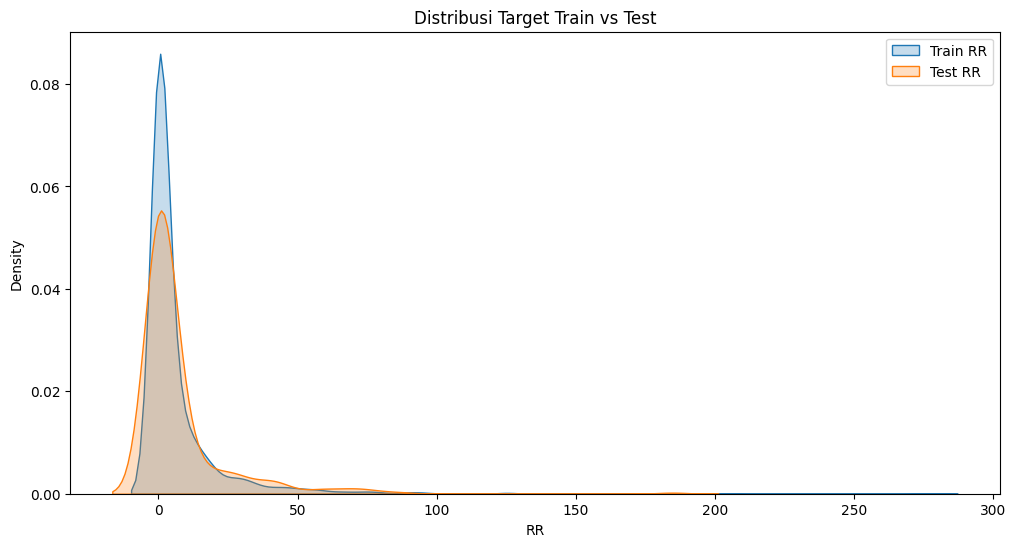

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.kdeplot(y_train, label='Train RR', fill=True)
sns.kdeplot(y_test, label='Test RR', fill=True)
plt.title("Distribusi Target Train vs Test")
plt.legend()
plt.show()


In [131]:
import pandas as pd
import numpy as np

corr = pd.concat([X_train, y_train], axis=1).corr()
target_corr = corr['RR'].sort_values(ascending=False)

print("Korelasi Fitur dengan Target:")
print(target_corr)


Korelasi Fitur dengan Target:
RR               1.000000
RR_diff1         0.630054
RR_7d            0.488228
RH_AVG           0.397900
RR_14d           0.392493
RR_30d           0.343710
Rain_7d_count    0.273764
RR_lag1          0.205826
month_sin        0.194030
RR_lag2          0.144035
month_cos        0.132766
DDD_X            0.103375
RR_lag7          0.100568
RR_lag3          0.099001
RH_diff1         0.044484
DDD_CAR          0.012741
FF_X             0.011858
FF_AVG           0.001426
day_cos         -0.000207
day_sin         -0.011507
temp_range      -0.059098
SS              -0.195308
TAVG_lag1       -0.311649
TX              -0.321259
TAVG            -0.389429
TN              -0.392595
Name: RR, dtype: float64


In [132]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

pred_train_rf = rf.predict(X_train_scaled)
pred_test_rf = rf.predict(X_test_scaled)

train_rmse = np.sqrt(mean_squared_error(y_train, pred_train_rf))
test_rmse  = np.sqrt(mean_squared_error(y_test, pred_test_rf))

train_mae = mean_absolute_error(y_train, pred_train_rf)
test_mae  = mean_absolute_error(y_test, pred_test_rf)

print("RF Train RMSE:", train_rmse)
print("RF Test RMSE :", test_rmse)
print("RF Train MAE:", train_mae)
print("RF Test MAE :", test_mae)


RF Train RMSE: 1.7571655046763552
RF Test RMSE : 2.3704041811425376
RF Train MAE: 0.333738546871672
RF Test MAE : 0.8248523144750799


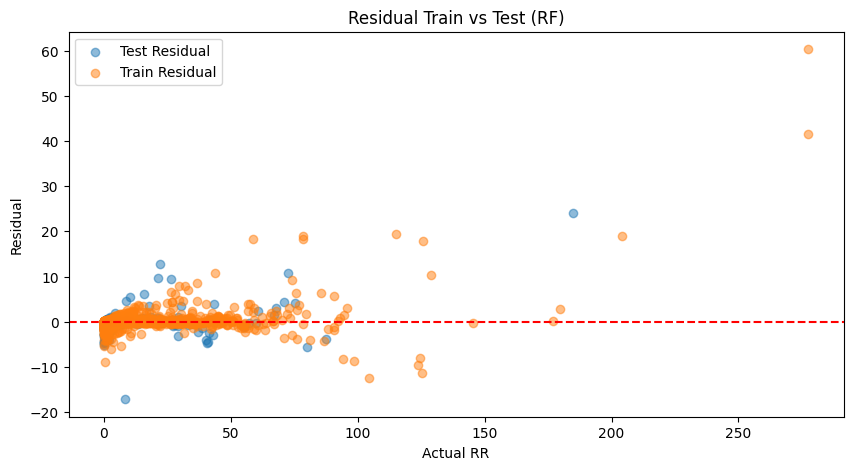

In [133]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_test - pred_test_rf, alpha=0.5, label="Test Residual")
plt.scatter(y_train, y_train - pred_train_rf, alpha=0.5, label="Train Residual")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual RR")
plt.ylabel("Residual")
plt.legend()
plt.title("Residual Train vs Test (RF)")
plt.show()


# Predict Future (Forecast)

In [ ]:
def build_future_features(history_df, future_date):
    history_df = history_df.copy()
    future_date = pd.to_datetime(future_date)

    last_30 = history_df.tail(30)

    base = history_df.iloc[-1].copy()
    base['TANGGAL'] = future_date

    # Date features
    base['month'] = future_date.month
    base['day']   = future_date.day

    base['month_sin'] = np.sin(2*np.pi*base['month']/12)
    base['month_cos'] = np.cos(2*np.pi*base['month']/12)
    base['day_sin']   = np.sin(2*np.pi*base['day']/31)
    base['day_cos']   = np.cos(2*np.pi*base['day']/31)

    base['temp_range'] = base['TX'] - base['TN']

    # def season(m):
    #     return 1 if m in [12,1,2] else 2 if m in [3,4,5] else 3 if m in [6,7,8] else 4
    # base['season'] = season(base['month'])

    temp = pd.concat([last_30, pd.DataFrame([base])], ignore_index=True)

    temp['RR_lag1'] = temp['RR'].shift(1)
    temp['RR_lag2'] = temp['RR'].shift(2)
    temp['RR_lag3'] = temp['RR'].shift(3)
    temp['RR_lag7'] = temp['RR'].shift(7)
    temp['TAVG_lag1'] = temp['TAVG'].shift(1)

    temp['RR_diff1'] = temp['RR'] - temp['RR_lag1']
    temp['RH_diff1'] = temp['RH_AVG'] - temp['RH_AVG'].shift(1)

    temp['RR_7d']  = temp['RR'].rolling(7).mean()
    temp['RR_14d'] = temp['RR'].rolling(14).mean()
    temp['RR_30d'] = temp['RR'].rolling(30).mean()

    temp['Rain_7d_count'] = temp['RR'].apply(lambda x: 1 if x > 0 else 0).rolling(7).sum()

    return temp.iloc[-1:]


In [ ]:
def forecast_7_days(
    df,
    start_date,
    features,
    scaler,
    rf,
    xgb,
    lstm_model
):
    history = df.copy()
    results = []

    current_date = pd.to_datetime(start_date)

    for i in range(7):
        next_date = current_date + pd.Timedelta(days=1)

        future_row = build_future_features(history, next_date)
        future_scaled = scaler.transform(future_row[features])

        # Predictions
        pred_rf  = rf.predict(future_scaled)[0]
        pred_xgb = xgb.predict(future_scaled)[0]
        pred_lstm = lstm_model.predict(
            future_scaled.reshape(1,1,-1)
        )[0][0]

        # Ensemble simple (optional)
        pred_mean = np.mean([pred_rf, pred_xgb, pred_lstm])

        results.append({
            "Tanggal": next_date,
            "RF": pred_rf,
            "XGB": pred_xgb,
            "LSTM": pred_lstm,
            "Ensemble": pred_mean
        })

        # Append prediction as RR
        new_row = future_row.copy()
        new_row['RR'] = pred_mean   # gunakan ensemble
        history = pd.concat([history, new_row], ignore_index=True)

        current_date = next_date

    return pd.DataFrame(results)


In [ ]:
future_7d = forecast_7_days(
    df=df,
    start_date="2025-12-01",
    features=features,
    scaler=scaler,
    rf=rf,
    xgb=xgb,
    lstm_model=model
)

print(future_7d)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
     Tanggal            RF       XGB      LSTM  Ensemble
0 2025-12-02  6.550262e-01  0.472585  0.090677  0.406096
1 2025-12-03  2.178406e-01  0.159403  0.049519  0.142254
2 2025-12-04  8.964781e-08  0.000580 -0.006036 -0.001819
3 2025-12-05  8.964781e-08  0.003584 -0.022989 -0.006468
4 2025-12-06  8.964781e-08  0.004428 -0.036096 -0.010556
5 2025-12-07  8.964781e-08  0.004679 -0.025008 -0.006776
6 2025-12-08  8.964781e-08  0.001535 -0.010978 -0.003148


Data shape: (4013, 11)
Date range: 2015-01-01 00:00:00 to 2025-11-30 00:00:00
Train: 3303 samples (2015-01-01 00:00:00 to 2023-12-31 00:00:00)
Val: 182 samples (2024-01-01 00:00:00 to 2024-06-30 00:00:00)
Test: 528 samples (2024-07-01 00:00:00 to 2025-11-30 00:00:00)
After dropna - Train: 3296, Val: 182, Test: 528
After creating multi-step targets - Train: 3289, Val: 175, Test: 521

Training models for Day +1
Validation  - MAE: 9.7397, RMSE: 18.5968
Test        - MAE: 8.1332, RMSE: 15.2300

Training models for Day +2
Validation  - MAE: 11.1521, RMSE: 19.0409
Test        - MAE: 9.7308, RMSE: 16.7764

Training models for Day +3
Validation  - MAE: 10.8099, RMSE: 18.7724
Test        - MAE: 9.8392, RMSE: 16.4652

Training models for Day +4
Validation  - MAE: 10.4645, RMSE: 18.9581
Test        - MAE: 10.2712, RMSE: 16.9018

Training models for Day +5
Validation  - MAE: 10.0319, RMSE: 18.4370
Test        - MAE: 9.9802, RMSE: 16.6920

Training models for Day +6
Validation  - MAE: 11.6210, RMSE

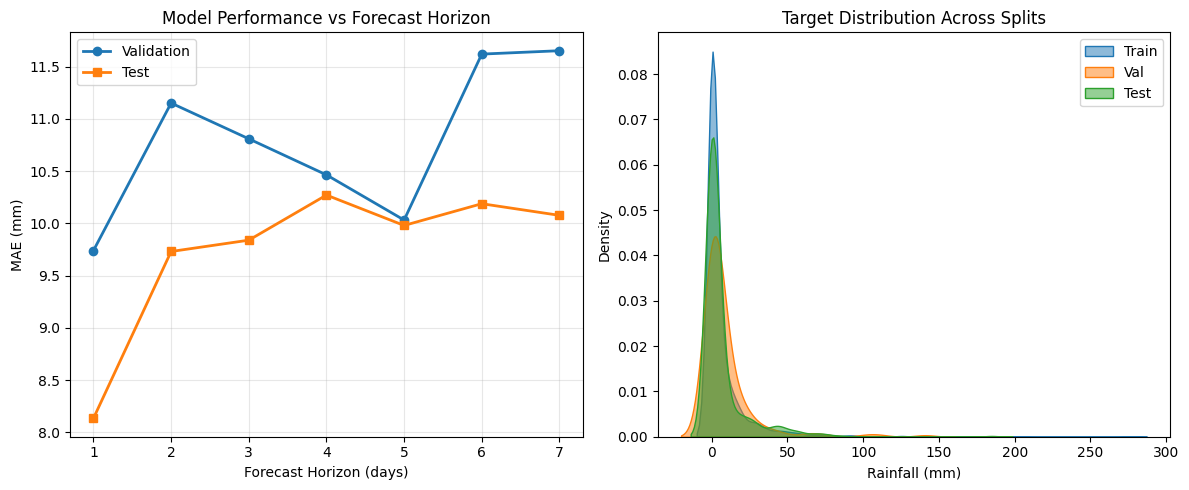

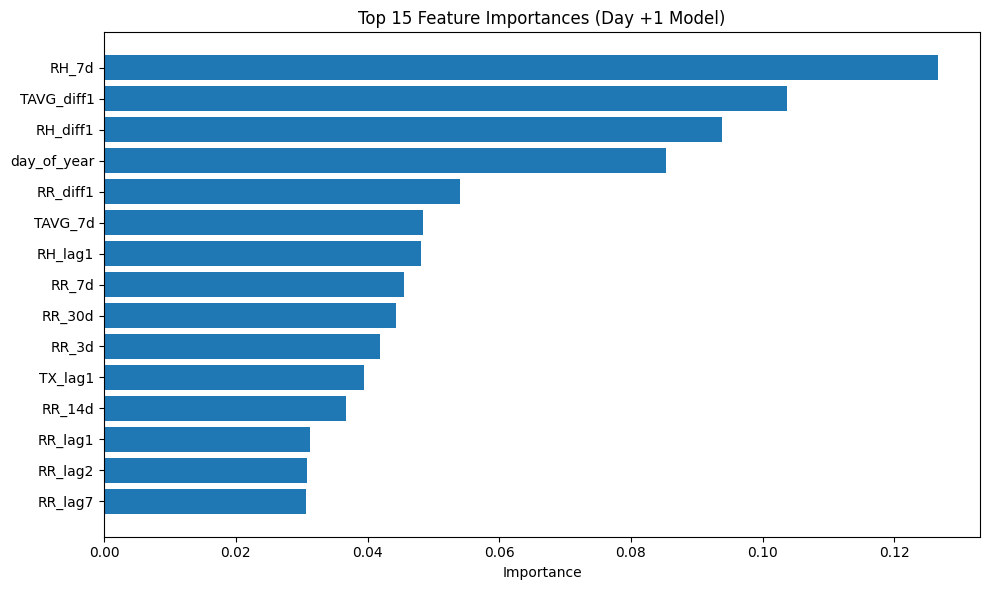


Top 10 Most Important Features:
        feature  importance
16        RH_7d    0.126668
10   TAVG_diff1    0.103728
9      RH_diff1    0.093900
22  day_of_year    0.085261
8      RR_diff1    0.054027
15      TAVG_7d    0.048479
5       RH_lag1    0.048105
12        RR_7d    0.045587
14       RR_30d    0.044271
11        RR_3d    0.041874


KeyError: "['RR_lag1', 'RR_lag2', 'RR_lag3', 'RR_lag7', 'TAVG_lag1', 'RH_lag1', 'TX_lag1', 'TN_lag1', 'RR_diff1', 'RH_diff1', 'TAVG_diff1', 'RR_3d', 'RR_7d', 'RR_14d', 'RR_30d', 'TAVG_7d', 'RH_7d', 'Rainy_days_7d'] not in index"

In [146]:
# %%
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import seaborn as sns
import matplotlib.pyplot as plt

# %%
# Load Data
df = pd.read_excel("updated_dataset_final - Copy.xlsx", parse_dates=['TANGGAL'])
df = df.sort_values('TANGGAL')
df = df.reset_index(drop=True)

print("Data shape:", df.shape)
print("Date range:", df['TANGGAL'].min(), "to", df['TANGGAL'].max())

# %%
def add_safe_features(df):
    """Add time-based and basic features"""
    df = df.copy()
    
    # Extract temporal features
    df['month'] = df['TANGGAL'].dt.month
    df['day'] = df['TANGGAL'].dt.day
    df['day_of_year'] = df['TANGGAL'].dt.dayofyear
    
    # Cyclical encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    
    # Temperature range
    df['temp_range'] = df['TX'] - df['TN']
    
    # Interaction features
    df['temp_humidity'] = df['TAVG'] * df['RH_AVG'] / 100
    
    return df

df = add_safe_features(df)

# %%
# IMPROVED SPLIT: Use more recent data for validation/test
train = df[df['TANGGAL'] < '2024-01-01']
val = df[(df['TANGGAL'] >= '2024-01-01') & (df['TANGGAL'] < '2024-07-01')]
test = df[df['TANGGAL'] >= '2024-07-01']

print(f"Train: {len(train)} samples ({train['TANGGAL'].min()} to {train['TANGGAL'].max()})")
print(f"Val: {len(val)} samples ({val['TANGGAL'].min()} to {val['TANGGAL'].max()})")
print(f"Test: {len(test)} samples ({test['TANGGAL'].min()} to {test['TANGGAL'].max()})")

# %%
def add_leakage_safe_lags(train, val, test):
    """Create lag features without data leakage"""
    full = pd.concat([train, val, test], axis=0)
    
    # Lag features for RR (target)
    full['RR_lag1'] = full['RR'].shift(1)
    full['RR_lag2'] = full['RR'].shift(2)
    full['RR_lag3'] = full['RR'].shift(3)
    full['RR_lag7'] = full['RR'].shift(7)
    
    # Lag features for weather variables (these exist in future!)
    full['TAVG_lag1'] = full['TAVG'].shift(1)
    full['RH_lag1'] = full['RH_AVG'].shift(1)
    full['TX_lag1'] = full['TX'].shift(1)
    full['TN_lag1'] = full['TN'].shift(1)
    
    # Difference features
    full['RR_diff1'] = full['RR'] - full['RR_lag1']
    full['RH_diff1'] = full['RH_AVG'] - full['RH_lag1']
    full['TAVG_diff1'] = full['TAVG'] - full['TAVG_lag1']
    
    # Rolling statistics (rainfall)
    full['RR_3d'] = full['RR'].rolling(3, min_periods=1).mean()
    full['RR_7d'] = full['RR'].rolling(7, min_periods=1).mean()
    full['RR_14d'] = full['RR'].rolling(14, min_periods=1).mean()
    full['RR_30d'] = full['RR'].rolling(30, min_periods=1).mean()
    
    # Rolling statistics (temperature)
    full['TAVG_7d'] = full['TAVG'].rolling(7, min_periods=1).mean()
    full['RH_7d'] = full['RH_AVG'].rolling(7, min_periods=1).mean()
    
    # Rainy days count
    full['Rainy_days_7d'] = full['RR'].apply(lambda x: 1 if x > 0 else 0).rolling(7, min_periods=1).sum()
    
    # Split back
    train2 = full.loc[train.index]
    val2 = full.loc[val.index]
    test2 = full.loc[test.index]
    
    return train2, val2, test2

train, val, test = add_leakage_safe_lags(train, val, test)

# %%
# Drop NaN values
train = train.dropna()
val = val.dropna()
test = test.dropna()

print(f"After dropna - Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

# %%
# SOLUTION 1: Direct Multi-Step Forecasting
# Train separate models for each forecast horizon (1-7 days)

def create_multistep_targets(df, max_horizon=7):
    """Create targets for each forecast day"""
    targets = {}
    for h in range(1, max_horizon + 1):
        targets[f'RR_t+{h}'] = df['RR'].shift(-h)
    return pd.DataFrame(targets, index=df.index)

# Create targets for training
train_targets = create_multistep_targets(train, max_horizon=7)
val_targets = create_multistep_targets(val, max_horizon=7)
test_targets = create_multistep_targets(test, max_horizon=7)

# Drop rows with NaN targets
train = train.iloc[:-7]
train_targets = train_targets.iloc[:-7]
val = val.iloc[:-7]
val_targets = val_targets.iloc[:-7]
test = test.iloc[:-7]
test_targets = test_targets.iloc[:-7]

print(f"After creating multi-step targets - Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

# %%
# Define features (REMOVED future unknowable features)
# We can only use: lags, rolling stats, and time features
features = [
    # Lag features (we know these from past)
    'RR_lag1', 'RR_lag2', 'RR_lag3', 'RR_lag7',
    'TAVG_lag1', 'RH_lag1', 'TX_lag1', 'TN_lag1',
    
    # Difference features
    'RR_diff1', 'RH_diff1', 'TAVG_diff1',
    
    # Rolling statistics
    'RR_3d', 'RR_7d', 'RR_14d', 'RR_30d',
    'TAVG_7d', 'RH_7d',
    'Rainy_days_7d',
    
    # Time features (we know future dates)
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'day_of_year'
]

# OPTIONAL: If you have weather forecast, add these:
# 'TN', 'TX', 'TAVG', 'RH_AVG', 'SS', 'FF_X', 'DDD_X', 'FF_AVG', 'DDD_CAR'

X_train = train[features]
X_val = val[features]
X_test = test[features]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# %%
# Train separate models for each horizon
models = {}
predictions_val = {}
predictions_test = {}

for horizon in range(1, 8):
    target_col = f'RR_t+{horizon}'
    y_train = train_targets[target_col]
    y_val = val_targets[target_col]
    y_test = test_targets[target_col]
    
    print(f"\n{'='*50}")
    print(f"Training models for Day +{horizon}")
    print(f"{'='*50}")
    
    # Random Forest
    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_scaled, y_train)
    pred_rf_val = rf.predict(X_val_scaled)
    pred_rf_test = rf.predict(X_test_scaled)
    
    # XGBoost
    xgb = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='reg:squarederror'
    )
    xgb.fit(X_train_scaled, y_train)
    pred_xgb_val = xgb.predict(X_val_scaled)
    pred_xgb_test = xgb.predict(X_test_scaled)
    
    # Ensemble (average)
    pred_ensemble_val = (pred_rf_val + pred_xgb_val) / 2
    pred_ensemble_test = (pred_rf_test + pred_xgb_test) / 2
    
    # Clip negative predictions to 0
    pred_ensemble_val = np.maximum(pred_ensemble_val, 0)
    pred_ensemble_test = np.maximum(pred_ensemble_test, 0)
    
    # Store models and predictions
    models[horizon] = {'rf': rf, 'xgb': xgb}
    predictions_val[horizon] = pred_ensemble_val
    predictions_test[horizon] = pred_ensemble_test
    
    # Evaluate
    mae_val = mean_absolute_error(y_val, pred_ensemble_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, pred_ensemble_val))
    mae_test = mean_absolute_error(y_test, pred_ensemble_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, pred_ensemble_test))
    
    print(f"Validation  - MAE: {mae_val:.4f}, RMSE: {rmse_val:.4f}")
    print(f"Test        - MAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}")

# %%
# Visualization: Performance across horizons
horizons = list(range(1, 8))
mae_vals = [mean_absolute_error(val_targets[f'RR_t+{h}'], predictions_val[h]) for h in horizons]
mae_tests = [mean_absolute_error(test_targets[f'RR_t+{h}'], predictions_test[h]) for h in horizons]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(horizons, mae_vals, marker='o', label='Validation', linewidth=2)
plt.plot(horizons, mae_tests, marker='s', label='Test', linewidth=2)
plt.xlabel('Forecast Horizon (days)')
plt.ylabel('MAE (mm)')
plt.title('Model Performance vs Forecast Horizon')
plt.legend()
plt.grid(True, alpha=0.3)

# Distribution comparison
plt.subplot(1, 2, 2)
sns.kdeplot(train_targets['RR_t+1'], label='Train', fill=True, alpha=0.5)
sns.kdeplot(val_targets['RR_t+1'], label='Val', fill=True, alpha=0.5)
sns.kdeplot(test_targets['RR_t+1'], label='Test', fill=True, alpha=0.5)
plt.title('Target Distribution Across Splits')
plt.xlabel('Rainfall (mm)')
plt.legend()

plt.tight_layout()
plt.show()

# %%
# Feature Importance (from Day +1 model)
rf_day1 = models[1]['rf']
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_day1.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (Day +1 Model)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# %%
# SOLUTION 2: Real-time Forecasting Function
# This uses the most recent data to predict next 7 days

def forecast_next_7days(df, features, scaler, models):
    """
    Forecast next 7 days using the latest available data
    
    Parameters:
    - df: Full dataframe with all historical data
    - features: List of feature names
    - scaler: Fitted StandardScaler
    - models: Dictionary of trained models for each horizon
    
    Returns:
    - DataFrame with predictions for next 7 days
    """
    # Get the latest row (most recent date)
    latest_data = df.iloc[-1:][features]
    latest_scaled = scaler.transform(latest_data)
    
    # Make predictions for each day
    results = []
    base_date = df['TANGGAL'].iloc[-1]
    
    for horizon in range(1, 8):
        next_date = base_date + pd.Timedelta(days=horizon)
        
        # Get predictions from both models
        rf_pred = models[horizon]['rf'].predict(latest_scaled)[0]
        xgb_pred = models[horizon]['xgb'].predict(latest_scaled)[0]
        
        # Ensemble
        pred = (rf_pred + xgb_pred) / 2
        pred = max(0, pred)  # Clip negative values
        
        results.append({
            'Date': next_date,
            'Day': horizon,
            'Predicted_Rainfall_mm': round(pred, 2),
            'RF_Prediction': round(rf_pred, 2),
            'XGB_Prediction': round(xgb_pred, 2)
        })
    
    return pd.DataFrame(results)

# %%
# Generate forecast for next 7 days from latest data
forecast_df = forecast_next_7days(
    df=df,
    features=features,
    scaler=scaler,
    models=models
)

print("\n" + "="*60)
print("FORECAST: Next 7 Days Rainfall Prediction")
print("="*60)
print(forecast_df.to_string(index=False))
print("="*60)

# %%
# Visualize forecast
plt.figure(figsize=(12, 6))

# Historical data (last 30 days)
last_30 = df.tail(30)
plt.plot(last_30['TANGGAL'], last_30['RR'], 
         marker='o', label='Historical', linewidth=2, color='blue')

# Forecast
plt.plot(forecast_df['Date'], forecast_df['Predicted_Rainfall_mm'], 
         marker='s', label='Forecast', linewidth=2, color='red', linestyle='--')

plt.axvline(x=df['TANGGAL'].iloc[-1], color='gray', linestyle=':', label='Today')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Rainfall Forecast: Next 7 Days')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# %%
# Model diagnostics: Residual analysis for Day +1
y_test_day1 = test_targets['RR_t+1']
pred_test_day1 = predictions_test[1]

residuals = y_test_day1 - pred_test_day1

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Actual vs Predicted
axes[0, 0].scatter(y_test_day1, pred_test_day1, alpha=0.5)
axes[0, 0].plot([0, y_test_day1.max()], [0, y_test_day1.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Rainfall (mm)')
axes[0, 0].set_ylabel('Predicted Rainfall (mm)')
axes[0, 0].set_title('Actual vs Predicted (Day +1)')
axes[0, 0].grid(True, alpha=0.3)

# Residual plot
axes[0, 1].scatter(pred_test_day1, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Rainfall (mm)')
axes[0, 1].set_ylabel('Residuals (mm)')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# Residual distribution
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuals (mm)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Residual Distribution')
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# Summary Statistics
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"\nDataset Split:")
print(f"  Train: {len(train)} samples")
print(f"  Val:   {len(val)} samples")
print(f"  Test:  {len(test)} samples")

print(f"\nDay +1 Forecast (Test Set):")
print(f"  MAE:  {mean_absolute_error(y_test_day1, pred_test_day1):.4f} mm")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_day1, pred_test_day1)):.4f} mm")
print(f"  Mean Actual Rainfall: {y_test_day1.mean():.4f} mm")
print(f"  Mean Predicted Rainfall: {pred_test_day1.mean():.4f} mm")

print(f"\nForecast Horizon Performance (Test Set):")
for h in range(1, 8):
    mae = mean_absolute_error(test_targets[f'RR_t+{h}'], predictions_test[h])
    print(f"  Day +{h}: MAE = {mae:.4f} mm")

print("="*60)